In [1]:
#pour réduire le temps de prédiction, prédire sur chacun des stores en parallèle sur
#plusieurs notebook et ensuire concat les resultats


In [2]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from tqdm import tqdm, tnrange
from multiprocessing import Pool, cpu_count

In [42]:
calendar_df = pd.read_csv('../../data/calendar.csv')
sales_train =  pd.read_csv('../../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../../data/sell_prices.csv')
submission_prophet = pd.read_csv('../../data/sample_submission.csv')
first_sub_pro = pd.read_csv('/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/submission/submission_prophet2_ALL.csv')

In [43]:
# permet de savoir si on se trouve dans la periode des saisons de NFL
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

In [44]:
def run_prophet(timeserie):
    #activer le yearly_seasonality
    model = Prophet(uncertainty_samples=False,yearly_seasonality=20, weekly_seasonality=False)
    #tuning avec les holidays des US de prophet, possibilité de mettre ses propres holidays
    model.add_country_holidays(country_name='US')
    #ajouter une seasonality sur le mois en prennant 1 mois = 28 jours
    model.add_seasonality(name='monthly', period=28, fourier_order=5)
    model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
    model.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
    
    model.fit(timeserie)
    future = model.make_future_dataframe(periods=28, include_history=False)
    future['on_season'] = future['ds'].apply(is_nfl_season)
    future['off_season'] = ~future['ds'].apply(is_nfl_season)
    forecast = model.predict(future)
    return forecast

In [59]:
#la boucle fait une prediction en fonction de l'index, qui represente 1 items dans l'ordre
# dans lequel ils sont dans la df sales_train

start_from_ob = 1200

#sales_train.shape[0]
for i in tnrange(6):
    temp_series = sales_train.iloc[i,start_from_ob:]
    temp_series.index = calendar_df['date'][start_from_ob:start_from_ob+len(temp_series)]
    temp_series =  pd.DataFrame(temp_series)
    temp_series = temp_series.reset_index()
    temp_series.columns = ['ds', 'y']
    
    #pour savoir si c'est la saison de NFL
    temp_series['on_season'] = temp_series['ds'].apply(is_nfl_season)
    temp_series['off_season'] = ~temp_series['ds'].apply(is_nfl_season)

    
    with Pool(cpu_count()) as p:
        forecast1 = p.map(run_prophet, [temp_series])

    submission_prophet.iloc[i,1:] = forecast1[0]['yhat'].values

    submission_prophet.iloc[:,1:]=submission_prophet.iloc[:,1:].where(submission_prophet.iloc[:,1:] > 0).fillna(0)

d_1195    0
d_1196    0
d_1197    0
d_1198    0
d_1199    1
         ..
d_1909    1
d_1910    3
d_1911    0
d_1912    1
d_1913    1
Name: 0, Length: 719, dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


d_1195    0
d_1196    0
d_1197    1
d_1198    0
d_1199    0
         ..
d_1909    1
d_1910    0
d_1911    0
d_1912    0
d_1913    0
Name: 1, Length: 719, dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


d_1195    2
d_1196    0
d_1197    0
d_1198    1
d_1199    0
         ..
d_1909    1
d_1910    0
d_1911    1
d_1912    1
d_1913    1
Name: 2, Length: 719, dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


d_1195    0
d_1196    2
d_1197    1
d_1198    2
d_1199    3
         ..
d_1909    0
d_1910    1
d_1911    3
d_1912    7
d_1913    2
Name: 3, Length: 719, dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


d_1195    0
d_1196    1
d_1197    0
d_1198    2
d_1199    1
         ..
d_1909    1
d_1910    2
d_1911    2
d_1912    2
d_1913    4
Name: 4, Length: 719, dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


d_1195    5
d_1196    0
d_1197    2
d_1198    0
d_1199    0
         ..
d_1909    0
d_1910    0
d_1911    2
d_1912    0
d_1913    0
Name: 5, Length: 719, dtype: object


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
all = submission_prophet.shape[0]/2
print(all)
print(all/4)
print(7622 + 7622 +7622 + 7624)

30490.0
7622.5
30490


In [57]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [16]:
first_sub_pro

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.762390,0.822506,0.706747,0.697028,0.749381,0.896512,0.773126,0.721608,0.780399,...,0.652023,0.798744,0.675646,0.625212,0.685971,0.571711,0.564449,0.620309,0.772072,0.654499
1,HOBBIES_1_002_CA_1_validation,0.146895,0.158603,0.175828,0.227727,0.255498,0.345949,0.288324,0.235567,0.255644,...,0.428996,0.505642,0.430983,0.358381,0.356298,0.356119,0.387401,0.391830,0.456778,0.372117
2,HOBBIES_1_003_CA_1_validation,0.646364,0.655806,0.654232,0.667377,0.706319,0.782001,0.693568,0.640724,0.651682,...,0.733379,0.814047,0.730241,0.681505,0.695909,0.699008,0.716368,0.758911,0.837442,0.750989
3,HOBBIES_1_004_CA_1_validation,1.565621,1.243145,1.181926,1.590931,1.587505,2.677860,3.287184,1.546214,1.234385,...,1.686533,2.787618,3.404683,1.668123,1.357106,1.304013,1.717426,1.714384,2.800880,3.401975
4,HOBBIES_1_005_CA_1_validation,0.694239,0.614323,0.713882,0.645696,0.718232,1.159326,1.068855,0.546693,0.482265,...,0.863915,1.373182,1.350780,0.895080,0.894019,1.072803,1.082545,1.230044,1.741510,1.715277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.225189,0.093887,0.126004,0.087226,0.140300,0.104034,0.186041,0.159492,0.040336,...,0.201617,0.185599,0.285324,0.273542,0.165873,0.219367,0.199201,0.267699,0.243348,0.333543
60976,FOODS_3_824_WI_3_evaluation,0.089006,0.001973,0.003428,0.014074,-0.038105,-0.004242,0.078246,0.052521,-0.042455,...,-0.099108,-0.050072,0.050888,0.046501,-0.024792,-0.004003,0.029166,0.002191,0.063347,0.174559
60977,FOODS_3_825_WI_3_evaluation,0.397447,0.243549,0.209129,0.192611,0.283792,0.568202,0.527096,0.489206,0.328561,...,0.280446,0.540158,0.476173,0.418094,0.240759,0.184479,0.148611,0.223821,0.496414,0.448304
60978,FOODS_3_826_WI_3_evaluation,1.729231,1.789361,1.681637,1.698416,1.677224,1.777119,1.895829,1.763083,1.833970,...,1.807351,1.902747,2.013328,1.868971,1.925014,1.809298,1.814311,1.777822,1.859238,1.956733


In [128]:
sales_train.shape[0]

30490

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


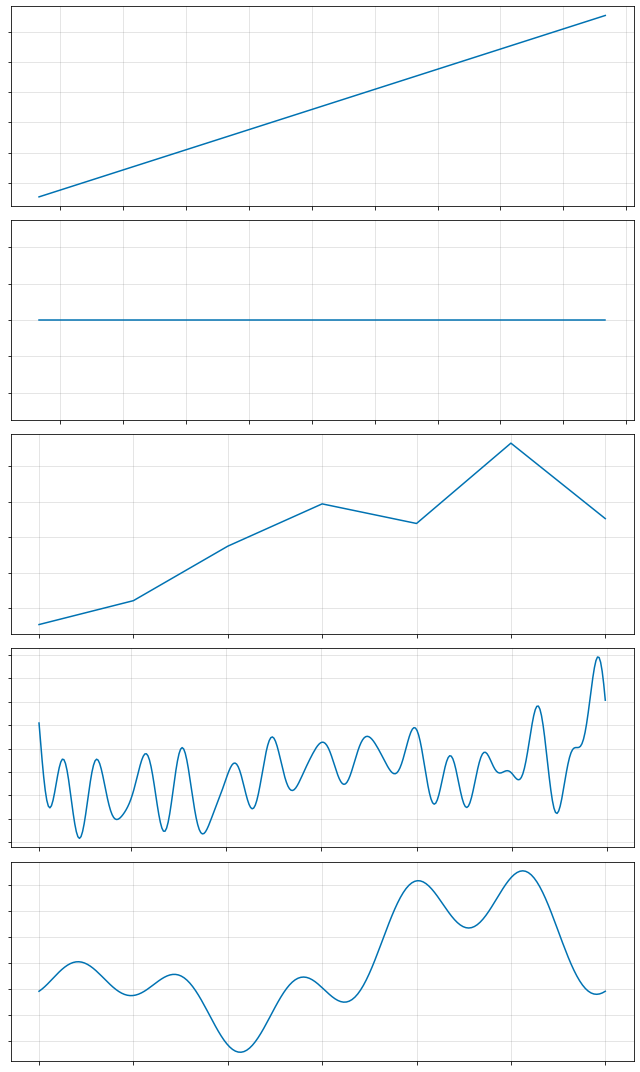

In [27]:
temp_series = sales_train.iloc[1,start_from_ob:]
temp_series.index = calendar_df['date'][start_from_ob:start_from_ob+len(temp_series)]
temp_series =  pd.DataFrame(temp_series)
temp_series = temp_series.reset_index()
temp_series.columns = ['ds', 'y']



model = Prophet(uncertainty_samples=False,yearly_seasonality=20)
#tuning avec les holidays des US de prophet, possibilité de mettre ses propres holidays
model.add_country_holidays(country_name='US')
model.add_seasonality(name='monthly', period=28, fourier_order=5)
model.fit(temp_series)
future = model.make_future_dataframe(periods=28, include_history=False)
forecast = model.predict(future)

fig = model.plot_components(forecast)


In [50]:
model.train_holiday_names

#avec model = Prophet(holidays=holidays) on peut specifier ces propes holidays donc on peut prendre la date du 
#superbowl pour les années précédentes et à venir grace à internet
# on a les dates des superbowl pour les prédictions donc pas besoin d'internet, juste de les extraire


NameError: name 'model' is not defined